# __Building an optimal image classification model using a convolutional neural network and Fashion MNIST data__

## __Abstract__

The Fashion MNIST dataset is a labelled dataset which was created by Keras as an alternative to the handwritten digits MNIST dataset. It comprises images of articles of clothing and footwear with each being labelled as belonging to one of 10 classes. It is a good candidate for learning about the application of deep learning approaches to multiclass image classification problems as it a clean dataset, of reasonable size and benchmark performances are available in the usual websites.

This notebook builds a multiclass classification model using a convolution neural network following the best practice guidance of_Deep Learning with Python_ (Chollet, 2018). It does this by using Chollet's 'Deep Learning Work Flow' approach with the aim of achieving a model which neither underfits nor overfits and is neither under-capacity nor over-capcity and has significant statistical power over a baseline model. Moreover, another model is built using the pre-trained VGG16 convnet to see how it compares to the one built from scratch.

While striving for the best results as possible, the datasets were altered to allow all the required techniques to be undertaken. These alterations were:

1. Subsetting of the data to a smaller dataset to demonstrate the power of applying data augmentation
2. Altering the size of the Fashion MNIST images and their channel/depth dimension to allow a pre-trained convolutional network to be used

Also for practical reasons the smaller datasets are perferred to reduce demanding run times that were initially experienced when using the full datasets

## __Contents__

1. Set up packages
2. Building an optimal model using convnets and the DLWP workflow
     - Step 1: Problem definition and data
     - Step 2: Success criteria
     - Step 3: Evaluation protocol
     - Step 4: Data preparation
     - Step 5: Outperforming a baseline
     - Step 6: Scaled up overfitting model
     - Step 7: Optimise the overfitting model
3. Use a pre-trained convnet to produce a model
4. Summary and conclusions
5. References

## __1. Set up packages__

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.applications import VGG16

## __2. Building an optimal model using convnets and the DLWP workflow__

The development of an optimal convnet model for the problem at hand follows approach of the workflow framework in section 4.5 of 'Deep Learning With Python' (Challot, 2018).

Please note that for readability superfluous cell output has been hidden.

### <font color='brown'>__Step 1: Problem definition and data__

#### __a. Problem definition:__
- Build a deep learning convnet model which can classify an image of a fashion item into one of 10 fashion categories
- Hypotheses:
  - the output classifications can be predicted from the input features (image pixel values)
  - the available data is sufficiently informative
  - The future is like the past

- This is a supervised multiclass classification problem aiming to find a mapping from multiple input features to a multiclass output (classes 0-9) which minimises a categorical crossentropy loss function using the parameter update method of RMSProp. As the data is balanced in terms of class representation accuracy can be used as an evaluation metric
- The model should have significant power in terms of beating the accuracy performance of the following baseline models:
  - random classifier - 10% (as the data is balanced)
  - a basic fully connected dense neural network

#### __b. Data samples and labels:__

The Fashion MNIST dataset is sourced from the Keras website (Keras, 2023) and comprises four datasets:

- 60,000 28 x 28 arrays representing grayscale images for training
- 60,000 1D arrays representing fashion item labels for training
- 10,000 28 x 28 arrays representing grayscale images for testing
- 10,000 1D arrays representing fashion item labels for testing

Each value in the 28 x 28 arrays is a grayscale number in the range of 0-255. \
Each value in the testing arrays is a number in the range of 0-9. \
There is no order to the data as it has been randomly shuffled.

The classes are:

<div style="position: absolute; left: 40px;">
  <table border="0">
    <tr>
      <td>1. Ankle boots</td>
      <td>6. Sandals</td>
    </tr>
    <tr>
      <td>2. Bags</td>
      <td>7. Shirts</td>
    </tr>
    <tr>
      <td>3. Coats</td>
      <td>8. Sneakers</td>
    </tr>
    <tr>
      <td>4. Dresses</td>
      <td>9. T-shirts/tops</td>
    </tr>
    <tr>
      <td>5. Pullovers</td>
      <td>10. Trousers</td>
    </tr>
  </table>
</div>

The code below imports the data from Keras and then:
- shows examples of the images
- shows that the datasets are balanced in terms of equal representation in each of the 10 fashion classes
- subsets the data to to a smaller data universe - one that is not too small however as to doubt the robustness of the results
   - Training of 8,000 random samples
   - Validation of 2,000 random samples
   - Test of 2,000 random samples

##### Import datasets from keras

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

##### Check size of the datasets

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


##### Review the array structure one sample

In [ ]:
#print(train_images[2])
#print(train_labels[2])

##### Review the first 25 training images

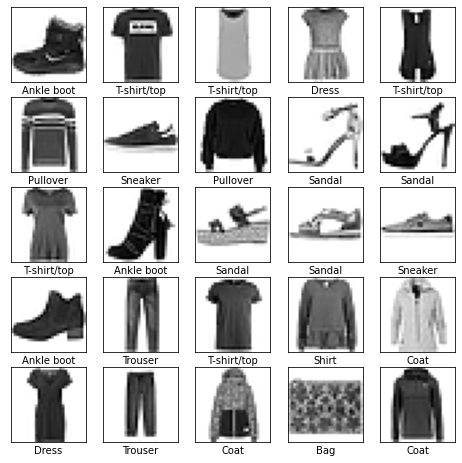

In [ ]:
# This excerpt of code was taken from the TensorFlow website  (TensorFlow, 2023)
# Label names taken from Keras MNIST page at: https://blog.tensorflow.org/2018/04/fashion-mnist-with-tfkeras.html
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

##### Check if the datasets are balanced in terms of class representation

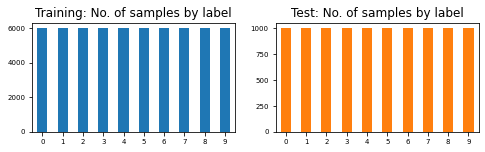

In [ ]:
train=pd.Series(train_labels).value_counts(dropna=False).sort_index()
test=pd.Series(test_labels).value_counts(dropna=False).sort_index()
both=pd.concat([train,test],axis=1)
both.plot(kind='bar',rot=0, figsize=[8,2],fontsize=7,title=['Training: No. of samples by label','Test: No. of samples by label'],legend=False,subplots=True,layout=[1,2]);

##### Subset the datasets

In [ ]:
train_images1=train_images[:8000]
train_labels1=train_labels[:8000]

valid_images1=train_images[58000:]
valid_labels1=train_labels[58000:]

test_images1=test_images[:2000]
test_labels1=test_labels[:2000]

### <font color='brown'>__Step 2: Success criteria__

- As this is a multiclass classification problem with a balanced dataset the success criteria will be to maximise accuracy (and minimise misclassification) and that the final model beats the performance of the baseline models. An accuracy of 100% is a perfect model which discriminates the 10 classes of fashion items perfectly while an accuracy of 10% is the same as the random model and offers no statistical power to discriminate classes

- A more intelligent baseline model of a fully-connected dense model has been chosen over the dumb random model to highlight the power that convnets have over these types of networks for image processing problems
- Monitoring of performance during training will also be done use accuracy on the validation data
- If the final convnet neural network model achieves better accuracy than the baseline model then it can be considered to have better statistical power and worthy of replacing them for implementation purposes - if required

### <font color='brown'>__Step 3: Evaluation protocol__

As there are a sizeable number of training samples (8,000 for training, 2,000 for testing and 2,000 for validation) k-fold validation is not considered and the hold-out validation approach is used instead.

The validation data is used for performance monitoring to aid hyperparameter tuning.

The overall model build approach will use a split of:

- 66.7% for model training (training)
- 16.7% for model optimisation (validation)
- 16.7% for model evaluation (test)

The size of the splits were chosen conservatively in terms of considering the need to minimise variation in performance measures. \
Once hyperparameters are tuned the model will be trained on all training data (including validation) and evaluated on the unseen test data.

### <font color='brown'>__Step 4: Data preparation__

To build convnet neural network models with the Fashion MNIST data the following preparatory steps were undertaken (below):

- Input tensors are homogeneously scaled down to float values between 0 and 1
- The tensors are reshaped to 'image height x image width x number of image channels' (here the number of channels=1 as it is a grayscale colour scheme)
- Class labels are one binary hot-encoded with values float formatted

In [ ]:
# Reshape and standardize the inputs
train_images2=train_images1.reshape((8000, 28, 28, 1))
train_images2=train_images2.astype('float32') / 255

test_images2=test_images1.reshape((2000, 28, 28, 1))
test_images2=test_images2.astype('float32') / 255

valid_images2=valid_images1.reshape((2000, 28, 28, 1))
valid_images2=valid_images2.astype('float32') / 255

# Reformat class labels to 0,1 with one hot-encoding
train_labels2=to_categorical(train_labels1)
test_labels2=to_categorical(test_labels1)
valid_labels2=to_categorical(valid_labels1)

### <font color='brown'>__Step 5: Outperforming a baseline__

To confirm whether the resulting convnet model is statistically powerful it is compared to a suitable baseline. For this project a baseline was established by building a simple fully-connected dense layer neural network. This baseline model achieved an accuracy of __75.0%__ using a simple architecture (see code below in 'a. Establish a baseline'). This will be the benchmark score to compare throughout the build of the convnet model.

A low capacity convolutional neural network model was then built to beat the baseline model (see 'b. Design a low capacity convnet model'). This model shows no significant evidence of underfitting or overfitting which is good but its statistical power, while __6.6__ percentage points higher then the baseline model, is still low with accuracy of only __81.6%__ achieved.

The low capacity model is considered a starting point for which the the optimal model must out-perform. Along with the scaled up over-fitted model of step 6 below the optimised model attempts to find the balance between low capacity and/or underfitting models and a high capacity overfitting model by considering different convnet architectures and regularisation techniques.

#### __a. Establish a baseline__

This baseline model comprises only one hidden dense layer of 128 units with no use of validation data for monitoring and no hyperparameter tuning or regularisation undertaken. \
It achieved an accuracy of __75.0%__ on test data.

In [ ]:
# Reshape and standardize the inputs into fully connected dense layers
train_images3 = train_images1.reshape((8000, 28 * 28))
train_images3 = train_images3.astype('float32') / 255

test_images3 = test_images1.reshape((2000, 28 * 28))
test_images3 = test_images3.astype('float32') / 255

# Reformat labels to 0,1 with one hot-encoding
train_labels3 = to_categorical(train_labels1)
test_labels3 = to_categorical(test_labels1)

# Create model using softmax as output layer, compile and fit it to training data
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(28 * 28, )))
model.add(layers.Dense(10, activation='softmax'))

# Compile using loss of 'categorical_crossentropy', optimizer of 'rmsprop' and evaluate on 'accuracy'
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit model to training data
model.fit(train_images3,
          train_labels3,
          epochs=5,
          batch_size=128)

Epoch 1/5
63/63 [==============================] - 1s 5ms/step - loss: 0.9361 - accuracy: 0.6862
Epoch 2/5
63/63 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.7843
Epoch 3/5
63/63 [==============================] - 0s 4ms/step - loss: 0.5375 - accuracy: 0.8084
Epoch 4/5
63/63 [==============================] - 0s 4ms/step - loss: 0.4987 - accuracy: 0.8248
Epoch 5/5
63/63 [==============================] - 0s 4ms/step - loss: 0.4581 - accuracy: 0.8397


In [ ]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_images3, test_labels3)
print('Test loss:',test_loss)
print('Test accuracy:',test_acc)

63/63 [==============================] - 0s 2ms/step - loss: 0.6497 - accuracy: 0.7500
Test loss: 0.6497176289558411
Test accuracy: 0.75


#### __b. Design a low capacity convnet model__

Low capacity convnet model with only 32K parameters, built with:
- one convolutional layer followed by one maxpooling layer to reduce the dimensionality ahead of input into the top dense layers
- 16 filters used in the convolutional layer and a high filter patch size of 7 x 7


- 2 fully connected dense layers on top which provide the classifier - returning softmax probabilities for each of the 10 labels - with 16 and 10 units respectively
- optimizer of 'rmsprop', SGD method of 'categorical crossentropy' for parameter optimizer and evaluation metric of 'accuracy' (as it's a multinomial classification problem)
- low number of 20 epochs with a high batch rate
- validation data used for monitoring purposes
- no hyperparameters tuning (number of layers, number of filters, patch size, number of neurons per layer, loss rate) or regularization

##### Build the network

In [ ]:
# Convolutional layers
model1 = models.Sequential()
model1.add(layers.Conv2D(16, (7, 7), activation='relu', input_shape=(28, 28, 1))) # Input shape is images of size 28 x 28 and colour is B & W so number of channels is 1
model1.add(layers.MaxPooling2D((2, 2)))

# Dense layers
model1.add(layers.Flatten()) # Flattening of above is required before input into dense layers
model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dense(10, activation='softmax'))

# Get model summary
model1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 22, 22, 16)        800       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 11, 11, 16)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 1936)              0         
                                                                 
 dense_27 (Dense)            (None, 16)                30992     
                                                                 
 dense_28 (Dense)            (None, 10)                170       
                                                                 
Total params: 31,962
Trainable params: 31,962
Non-trainable params: 0
_________________________________________________

##### Compile and fit the convnet to the training data

In [ ]:
model1.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history1=model1.fit(train_images2,
                    train_labels2,
                    epochs=20,
                    batch_size=512,
                    validation_data=(valid_images2, valid_labels2),
                    verbose=1)

Epoch 1/20
16/16 [==============================] - 3s 141ms/step - loss: 1.8437 - accuracy: 0.3581 - val_loss: 1.3893 - val_accuracy: 0.5255
Epoch 2/20
16/16 [==============================] - 2s 126ms/step - loss: 1.2813 - accuracy: 0.5611 - val_loss: 1.0464 - val_accuracy: 0.6940
Epoch 3/20
16/16 [==============================] - 2s 132ms/step - loss: 0.9994 - accuracy: 0.6794 - val_loss: 0.9392 - val_accuracy: 0.6915
Epoch 4/20
16/16 [==============================] - 2s 148ms/step - loss: 0.8826 - accuracy: 0.7100 - val_loss: 0.9093 - val_accuracy: 0.6635
Epoch 5/20
16/16 [==============================] - 2s 135ms/step - loss: 0.8113 - accuracy: 0.7274 - val_loss: 0.7234 - val_accuracy: 0.7510
Epoch 6/20
16/16 [==============================] - 2s 126ms/step - loss: 0.7544 - accuracy: 0.7358 - val_loss: 0.7498 - val_accuracy: 0.7460
Epoch 7/20
16/16 [==============================] - 2s 123ms/step - loss: 0.7119 - accuracy: 0.7485 - val_loss: 0.6640 - val_accuracy: 0.7620
Epoch 

##### Plot the training and validation scores by epoch

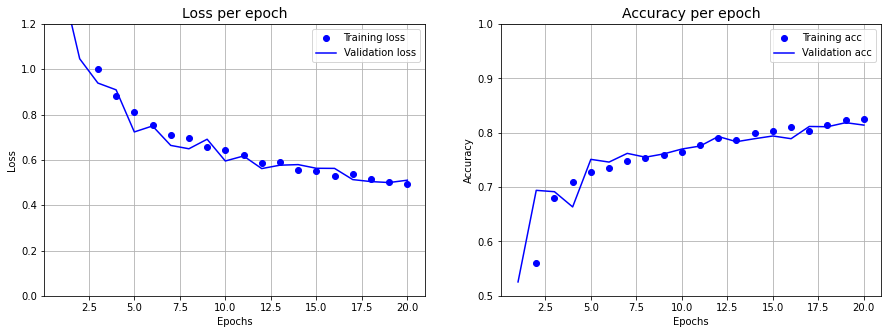

In [ ]:
def plot_results(history,y1,y2,y3,y4):

    plt.figure(figsize=(15,5))

    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(1,len(loss) + 1)
    plt.subplot(1, 2, 1)
    plt.plot(epochs,loss,'bo',label='Training loss')
    plt.plot(epochs,val_loss,'b', label='Validation loss')
    plt.ylim((y1, y2))
    #plt.ylim((0.0, 1.0))
    plt.title('Loss per epoch',fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.ylim((y3, y4))
    #plt.ylim((0.5, 1.0))
    plt.title('Accuracy per epoch',fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.show()

plot_results(history1,0.0,1.2,0.5,1.0)

##### Evaluate the model on test dataset

In [ ]:
test_loss, test_acc = model1.evaluate(test_images2, test_labels2)
print('Test loss:',test_loss)
print('Test accuracy:',test_acc)

63/63 [==============================] - 1s 19ms/step - loss: 0.5199 - accuracy: 0.8160
Test loss: 0.5198803544044495
Test accuracy: 0.8159999847412109


### <font color='brown'>__Step 6: Scaled up overfitting model__

Here a relatively larger scale model with __534K__ parameters is built with the intention to overfit. This will provide insight into where overfitting occurs (in terms of epochs) and provide an upper bound on the size of the architecture of a convnet when building the optimal model. The architecture of this model includes:

- three 2D convolutional layers
- filters ranging from 64 to 128
- filter patches of size 2 x 2 and 3 x 3
- two MaxPooling layers at the bottom (to control dimensionality)
- three dense layers
- the last dense layer being an output layer with softmax activation function (to supply class probabilities)

It was fitted to the same data as the low-capacity model but with more epochs and a smaller batch size. It showed:
- accuracy of __85.2%__ which is __3.6__ percentage points higher than that of the low-capacity model
- overfitting starting to occur at epoch __12__

Notes:

- As the images are only 28 x 28 x 1 there is limit in the number of max pooling layers that can be used as it reduces the dimensions quickly ahead of input into subsequent layers
- To maintain maximum information retrieval, a small filter patch of size 2 x 2 was used on the first convolution layer

##### Build the network

In [ ]:
# Convolutional layers
model2 = models.Sequential()
model2.add(layers.Conv2D(64, (2, 2), activation='relu',input_shape=(28, 28, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Dense layers
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

# Get model summary
model2.summary()

##### Compile and fit the convnet to the training data

In [ ]:
model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

history2=model2.fit(train_images2,
                    train_labels2,
                    epochs=40,
                    batch_size=128,
                    validation_data=(valid_images2, valid_labels2),
                    verbose=1)

Epoch 1/40
63/63 [==============================] - 18s 276ms/step - loss: 1.2810 - accuracy: 0.5196 - val_loss: 0.8088 - val_accuracy: 0.7025
Epoch 2/40
63/63 [==============================] - 17s 274ms/step - loss: 0.6855 - accuracy: 0.7360 - val_loss: 0.6107 - val_accuracy: 0.7630
Epoch 3/40
63/63 [==============================] - 17s 276ms/step - loss: 0.5621 - accuracy: 0.7862 - val_loss: 0.6590 - val_accuracy: 0.7340
Epoch 4/40
63/63 [==============================] - 18s 279ms/step - loss: 0.4862 - accuracy: 0.8164 - val_loss: 0.5919 - val_accuracy: 0.7885
Epoch 5/40
63/63 [==============================] - 18s 278ms/step - loss: 0.4376 - accuracy: 0.8369 - val_loss: 0.4681 - val_accuracy: 0.8180
Epoch 6/40
63/63 [==============================] - 18s 283ms/step - loss: 0.3945 - accuracy: 0.8516 - val_loss: 0.4579 - val_accuracy: 0.8260
Epoch 7/40
63/63 [==============================] - 17s 273ms/step - loss: 0.3598 - accuracy: 0.8692 - val_loss: 0.4462 - val_accuracy: 0.8335

##### Plot the training and validation scores by epoch

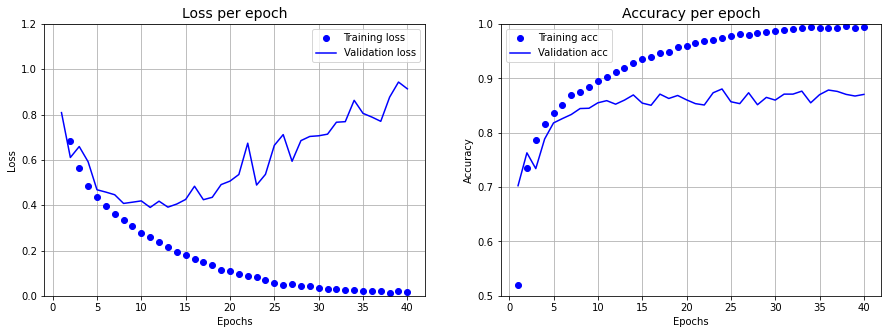

In [ ]:
plot_results(history2,0.0,1.2,0.5,1.0)

##### Find when the model starts to overfit

In [ ]:
# Find lowest accuracy for validation data
print('Minimum loss score for validation dataset:',min(history2.history['val_loss']))
print('Minimum loss score occurs at epoch:',history2.history['val_loss'].index(min(history2.history['val_loss']))+1)
print('')
# Find highest accuracy for validation data
print('Maximum accuracy score for validation dataset:',max(history2.history['val_accuracy']))
print('Maximum accuracy score occurs at epoch:',history2.history['val_accuracy'].index(max(history2.history['val_accuracy']))+1)

Minimum loss score for validation dataset: 0.3901433050632477
Minimum loss score occurs at epoch: 11

Maximum accuracy score for validation dataset: 0.8805000185966492
Maximum accuracy score occurs at epoch: 24


##### Evaluate the model on test dataset

In [ ]:
test_loss, test_acc = model1.evaluate(test_images2, test_labels2)
print('Test loss:',test_loss)
print('Test accuracy:',test_acc)

63/63 [==============================] - 0s 5ms/step - loss: 0.4342 - accuracy: 0.8520
Test loss: 0.43423593044281006
Test accuracy: 0.8519999980926514


### <font color='brown'>__Step 7: Optimise the overfitting model__

Here we want to find a model that ideally sits on the cusp of under-/overfitting and which is not too low-capacity or too high-capacity so it will generalise well to new data. Starting with the scaled-up model above an iterative approach is used to alter it by the following in turn:

01. reducing the number of epochs to 11
02. removing the first unit dense layer
03. reducing the number of units in the dense layers
04. undertaking L2 regularisation on the dense layers
05. applying dropout after first dense layers
06. apply batch normalisation to normalise the inputs into each convolutional layer
07. adjusting the first filter to size 3 x 3
08. applying 'padding' to get the same sized output feature maps as input feature maps allowing for more accurate analysis of images
09. applying data augmentation to synthetically increase the volume of images for training

An automated grid search-type approach could be created to tune all of these hyperparameters in combination but this would be computationally very expansive. So a simple cherry-picking approach is used instead that starts with the most obvious actions such as reducing the size of the network and then subsequently applying more specialist techniques like data augmentation, rolling forward these architecture alterations to the next iteration if they help increase model performance.

The final resulting architecture actually increases in terms of parameters to __1.8M__ due to the flattened layer (ahead of input into the classifier) being considerably larger than previously due to the changes made to the convolutional layers.
    
When this model is trained on the full training data and evaluated on the test hold-out data it achieves a relatively low loss of __0.394__ and shows little evidence of underfitting or overfitting. It achieves an accuracy of __87.5%__ which easily surpasses the __75.0%__ of the baseline model by __12.5__ percentage points

#### __a. Reduce underfitting by applying architecture alterations__

##### __Create a function to compile, fit and evaluate of each model iteration__

In [ ]:
def model_run_eval(model):

    # Compile
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # fit
    history=model.fit(train_images2,
                      train_labels2,
                      epochs=11,
                      batch_size=128,
                      validation_data=(valid_images2, valid_labels2),
                      verbose=1)

    # Plot the training and validation scores by epoch
    plot_results(history,0.0,1.2,0.5,1.0)

    # Evaluate the model on test dataset
    test_loss, test_acc = model.evaluate(test_images2, test_labels2)
    print('Test loss:',test_loss)
    print('Test accuracy:',test_acc)

##### __Iteration 1 - reducing the number of epochs to 11__

Results show improvement versus the high capacity model so roll forward this architecture\
Test loss: 0.40828195214271545 vs 0.43423593044281006\
Test accuracy: 0.8575000166893005 vs 0.8519999980926514\
No under/overfitting

Epoch 1/11
63/63 [==============================] - 19s 283ms/step - loss: 1.2823 - accuracy: 0.5245 - val_loss: 0.8157 - val_accuracy: 0.6945
Epoch 2/11
63/63 [==============================] - 18s 279ms/step - loss: 0.6720 - accuracy: 0.7450 - val_loss: 0.6731 - val_accuracy: 0.7515
Epoch 3/11
63/63 [==============================] - 17s 277ms/step - loss: 0.5563 - accuracy: 0.7895 - val_loss: 0.5210 - val_accuracy: 0.8070
Epoch 4/11
63/63 [==============================] - 18s 282ms/step - loss: 0.4828 - accuracy: 0.8186 - val_loss: 0.6936 - val_accuracy: 0.7560
Epoch 5/11
63/63 [==============================] - 18s 283ms/step - loss: 0.4290 - accuracy: 0.8429 - val_loss: 0.4211 - val_accuracy: 0.8370
Epoch 6/11
63/63 [==============================] - 17s 275ms/step - loss: 0.3877 - accuracy: 0.8585 - val_loss: 0.5258 - val_accuracy: 0.8030
Epoch 7/11
63/63 [==============================] - 18s 279ms/step - loss: 0.3507 - accuracy: 0.8725 - val_loss: 0.4753 - val_accuracy: 0.8195

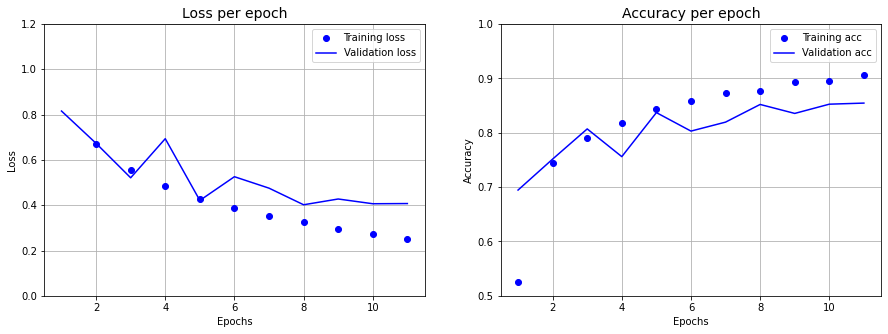

63/63 [==============================] - 2s 26ms/step - loss: 0.4083 - accuracy: 0.8575
Test loss: 0.40828195214271545
Test accuracy: 0.8575000166893005


In [ ]:
# Convolutional layers
model = models.Sequential()
model.add(layers.Conv2D(64, (2, 2), activation='relu',input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model_run_eval(model)

##### __Iteration 2 - remove the first unit dense layer__

Results show no improvement so roll back to iteration 1 architecture\
Test loss: 0.429411262273788453 \
Test accuracy:  0.8450000286102295 \
No under/overfitting

Epoch 1/11
63/63 [==============================] - 18s 270ms/step - loss: 1.1780 - accuracy: 0.5566 - val_loss: 0.7476 - val_accuracy: 0.7200
Epoch 2/11
63/63 [==============================] - 17s 275ms/step - loss: 0.6518 - accuracy: 0.7541 - val_loss: 0.6863 - val_accuracy: 0.7290
Epoch 3/11
63/63 [==============================] - 17s 267ms/step - loss: 0.5443 - accuracy: 0.7960 - val_loss: 0.5431 - val_accuracy: 0.7995
Epoch 4/11
63/63 [==============================] - 17s 266ms/step - loss: 0.4782 - accuracy: 0.8263 - val_loss: 0.5138 - val_accuracy: 0.8050
Epoch 5/11
63/63 [==============================] - 17s 270ms/step - loss: 0.4242 - accuracy: 0.8461 - val_loss: 0.4659 - val_accuracy: 0.8245
Epoch 6/11
63/63 [==============================] - 17s 273ms/step - loss: 0.3858 - accuracy: 0.8597 - val_loss: 0.4290 - val_accuracy: 0.8435
Epoch 7/11
63/63 [==============================] - 18s 280ms/step - loss: 0.3655 - accuracy: 0.8668 - val_loss: 0.4962 - val_accuracy: 0.8055

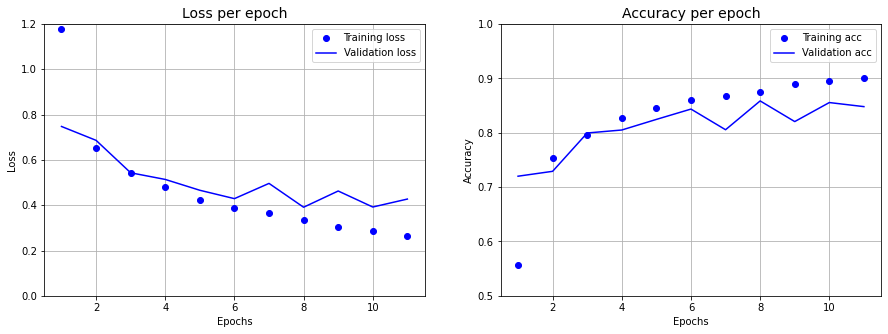

63/63 [==============================] - 1s 23ms/step - loss: 0.4294 - accuracy: 0.8450
Test loss: 0.42941126227378845
Test accuracy: 0.8450000286102295


In [ ]:
# Convolutional layers
model = models.Sequential()
model.add(layers.Conv2D(64, (2, 2), activation='relu',input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model_run_eval(model)

##### __Iteration 3 - reduce the number of units in the dense layers__

Results show no improvement so roll back to iteration 1 architecture\
Test loss: 0.6133295297622681 \
Test accuracy:  0.8019999861717224 \
Overfitting evident

Epoch 1/11
63/63 [==============================] - 18s 275ms/step - loss: 1.3513 - accuracy: 0.4986 - val_loss: 0.8127 - val_accuracy: 0.6755
Epoch 2/11
63/63 [==============================] - 18s 280ms/step - loss: 0.7111 - accuracy: 0.7318 - val_loss: 0.7119 - val_accuracy: 0.7210
Epoch 3/11
63/63 [==============================] - 17s 274ms/step - loss: 0.5839 - accuracy: 0.7800 - val_loss: 0.5635 - val_accuracy: 0.7895
Epoch 4/11
63/63 [==============================] - 18s 281ms/step - loss: 0.5069 - accuracy: 0.8121 - val_loss: 0.4846 - val_accuracy: 0.8170
Epoch 5/11
63/63 [==============================] - 17s 271ms/step - loss: 0.4617 - accuracy: 0.8309 - val_loss: 0.5140 - val_accuracy: 0.8060
Epoch 6/11
63/63 [==============================] - 17s 264ms/step - loss: 0.4123 - accuracy: 0.8521 - val_loss: 0.5044 - val_accuracy: 0.8145
Epoch 7/11
63/63 [==============================] - 17s 275ms/step - loss: 0.3877 - accuracy: 0.8589 - val_loss: 0.4196 - val_accuracy: 0.8425

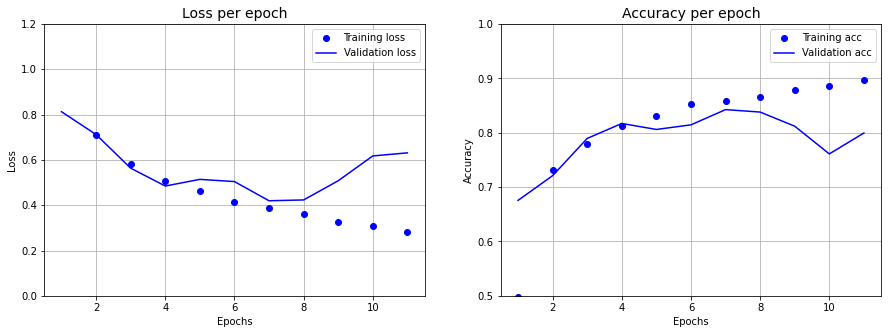

63/63 [==============================] - 2s 27ms/step - loss: 0.6133 - accuracy: 0.8020
Test loss: 0.6133295297622681
Test accuracy: 0.8019999861717224


In [ ]:
# Convolutional layers
model = models.Sequential()
model.add(layers.Conv2D(64, (2, 2), activation='relu',input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model_run_eval(model)

##### __Iteration 4 - undertake L2 regularisation on the dense layers__

Results show no improvement so roll back to iteration 1 architecture\
Test loss: 0.5948675870895386 \
Test accuracy: 0.809499979019165  \
No under/overfitting

Epoch 1/11
63/63 [==============================] - 19s 284ms/step - loss: 1.6849 - accuracy: 0.5288 - val_loss: 1.1364 - val_accuracy: 0.6965
Epoch 2/11
63/63 [==============================] - 18s 282ms/step - loss: 1.0095 - accuracy: 0.7310 - val_loss: 0.8362 - val_accuracy: 0.7705
Epoch 3/11
63/63 [==============================] - 18s 285ms/step - loss: 0.8086 - accuracy: 0.7841 - val_loss: 0.8127 - val_accuracy: 0.7685
Epoch 4/11
63/63 [==============================] - 18s 279ms/step - loss: 0.7110 - accuracy: 0.7989 - val_loss: 0.7225 - val_accuracy: 0.7860
Epoch 5/11
63/63 [==============================] - 17s 272ms/step - loss: 0.6180 - accuracy: 0.8273 - val_loss: 0.8037 - val_accuracy: 0.7450
Epoch 6/11
63/63 [==============================] - 17s 272ms/step - loss: 0.5614 - accuracy: 0.8420 - val_loss: 0.6051 - val_accuracy: 0.8225
Epoch 7/11
63/63 [==============================] - 17s 277ms/step - loss: 0.5112 - accuracy: 0.8571 - val_loss: 0.7009 - val_accuracy: 0.7745

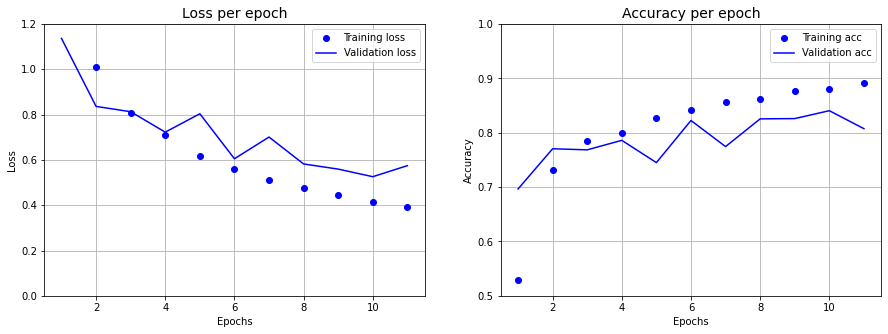

63/63 [==============================] - 2s 24ms/step - loss: 0.5949 - accuracy: 0.8095
Test loss: 0.5948675870895386
Test accuracy: 0.809499979019165


In [ ]:
# Convolutional layers
model = models.Sequential()
model.add(layers.Conv2D(64, (2, 2), activation='relu',input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(10, activation='softmax'))

model_run_eval(model)

##### __Iteration 5 - apply dropout after dense layers__

Results show improvement so roll forward this architecture\
Test loss: 0.4034961462020874  \
Test accuracy: 0.8604999780654907    \
No significant under/overfitting

Epoch 1/11
63/63 [==============================] - 20s 301ms/step - loss: 1.3496 - accuracy: 0.4992 - val_loss: 0.7643 - val_accuracy: 0.7130
Epoch 2/11
63/63 [==============================] - 19s 302ms/step - loss: 0.7467 - accuracy: 0.7266 - val_loss: 0.5640 - val_accuracy: 0.7835
Epoch 3/11
63/63 [==============================] - 21s 331ms/step - loss: 0.6057 - accuracy: 0.7784 - val_loss: 0.5414 - val_accuracy: 0.7880
Epoch 4/11
63/63 [==============================] - 21s 332ms/step - loss: 0.5239 - accuracy: 0.8058 - val_loss: 0.6008 - val_accuracy: 0.7715
Epoch 5/11
63/63 [==============================] - 19s 309ms/step - loss: 0.4809 - accuracy: 0.8275 - val_loss: 0.4470 - val_accuracy: 0.8320
Epoch 6/11
63/63 [==============================] - 19s 299ms/step - loss: 0.4274 - accuracy: 0.8438 - val_loss: 0.5050 - val_accuracy: 0.8195
Epoch 7/11
63/63 [==============================] - 18s 291ms/step - loss: 0.3989 - accuracy: 0.8593 - val_loss: 0.4207 - val_accuracy: 0.8390

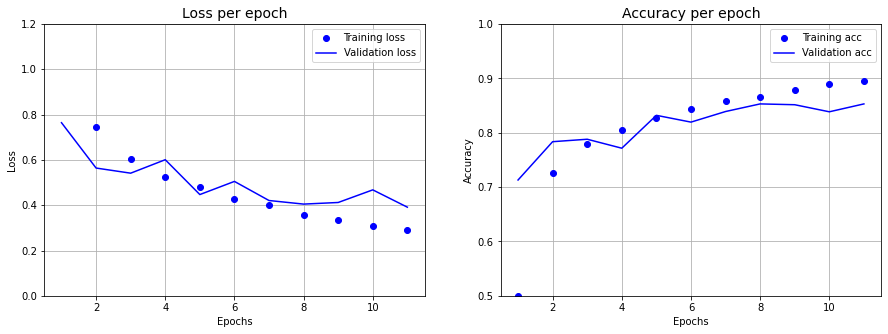

63/63 [==============================] - 2s 25ms/step - loss: 0.4035 - accuracy: 0.8605
Test loss: 0.4034961462020874
Test accuracy: 0.8604999780654907


In [ ]:
# Convolutional layers
model = models.Sequential()
model.add(layers.Conv2D(64, (2, 2), activation='relu',input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model_run_eval(model)

##### __Iteration 6 - apply batch normalisation to normalise the inputs into each convolutional layer__

Results show improvement on accuracy but the training model does not generalise well with significant differences between training and validation in loss and accuracy scores over the epochs so roll back to iteration 5 architecture\
Test loss: 0.6232907772064209   \
Test accuracy: 0.8579999804496765     \
Extremely high loss for validation

Epoch 1/11
63/63 [==============================] - 25s 385ms/step - loss: 0.8629 - accuracy: 0.7060 - val_loss: 2.5052 - val_accuracy: 0.1030
Epoch 2/11
63/63 [==============================] - 24s 374ms/step - loss: 0.5507 - accuracy: 0.8114 - val_loss: 3.5435 - val_accuracy: 0.1980
Epoch 3/11
63/63 [==============================] - 27s 436ms/step - loss: 0.4172 - accuracy: 0.8493 - val_loss: 4.1120 - val_accuracy: 0.1075
Epoch 4/11
63/63 [==============================] - 24s 375ms/step - loss: 0.3571 - accuracy: 0.8784 - val_loss: 3.9904 - val_accuracy: 0.2800
Epoch 5/11
63/63 [==============================] - 25s 397ms/step - loss: 0.2991 - accuracy: 0.8971 - val_loss: 3.0875 - val_accuracy: 0.4150
Epoch 6/11
63/63 [==============================] - 23s 370ms/step - loss: 0.2570 - accuracy: 0.9076 - val_loss: 3.9062 - val_accuracy: 0.4365
Epoch 7/11
63/63 [==============================] - 23s 370ms/step - loss: 0.2190 - accuracy: 0.9239 - val_loss: 2.2293 - val_accuracy: 0.6495

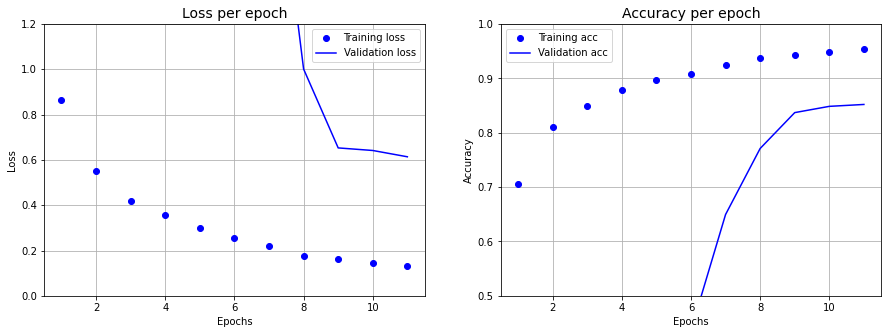

63/63 [==============================] - 2s 30ms/step - loss: 0.6233 - accuracy: 0.8580
Test loss: 0.6232907772064209
Test accuracy: 0.8579999804496765


In [ ]:
# Convolutional layers
model = models.Sequential()
model.add(layers.Conv2D(64, (2, 2), activation='relu',input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model_run_eval(model)

##### __Iteration 7 - adjusting the first filter to size 3 x 3__

Results show noticeable improvement so roll forward this architecture\
Test loss: 0.3863731920719147\
Test accuracy: 0.8675000071525574\
No significant under/overfitting

Epoch 1/11
63/63 [==============================] - 18s 273ms/step - loss: 1.2644 - accuracy: 0.5296 - val_loss: 0.6987 - val_accuracy: 0.7490
Epoch 2/11
63/63 [==============================] - 17s 271ms/step - loss: 0.7093 - accuracy: 0.7383 - val_loss: 0.6824 - val_accuracy: 0.7360
Epoch 3/11
63/63 [==============================] - 17s 275ms/step - loss: 0.5829 - accuracy: 0.7879 - val_loss: 0.6268 - val_accuracy: 0.7850
Epoch 4/11
63/63 [==============================] - 18s 288ms/step - loss: 0.5109 - accuracy: 0.8191 - val_loss: 0.5177 - val_accuracy: 0.8030
Epoch 5/11
63/63 [==============================] - 17s 276ms/step - loss: 0.4573 - accuracy: 0.8347 - val_loss: 0.4197 - val_accuracy: 0.8450
Epoch 6/11
63/63 [==============================] - 17s 275ms/step - loss: 0.4140 - accuracy: 0.8522 - val_loss: 0.4259 - val_accuracy: 0.8435
Epoch 7/11
63/63 [==============================] - 17s 271ms/step - loss: 0.3714 - accuracy: 0.8681 - val_loss: 0.4275 - val_accuracy: 0.8405

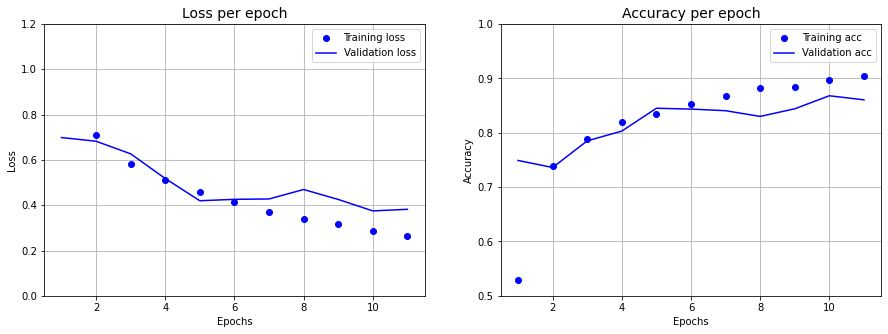

63/63 [==============================] - 1s 23ms/step - loss: 0.3864 - accuracy: 0.8675
Test loss: 0.3863731920719147
Test accuracy: 0.8675000071525574


In [ ]:
# Convolutional layers
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model_run_eval(model)

##### __Iteration 8 - applying 'padding' to get the same sized output feature maps as input feature maps allowing for more accurate analysis of images__

Results show significant improvement so roll forward this architecture\
Test loss: 0.3321758210659027\
Test accuracy: 0.8889999985694885\
No significant under/overfitting

Epoch 1/11
63/63 [==============================] - 36s 555ms/step - loss: 1.2205 - accuracy: 0.5472 - val_loss: 0.6990 - val_accuracy: 0.7315
Epoch 2/11
63/63 [==============================] - 35s 558ms/step - loss: 0.6566 - accuracy: 0.7617 - val_loss: 0.6299 - val_accuracy: 0.7555
Epoch 3/11
63/63 [==============================] - 36s 570ms/step - loss: 0.5166 - accuracy: 0.8112 - val_loss: 0.4540 - val_accuracy: 0.8295
Epoch 4/11
63/63 [==============================] - 37s 584ms/step - loss: 0.4455 - accuracy: 0.8374 - val_loss: 0.4490 - val_accuracy: 0.8325
Epoch 5/11
63/63 [==============================] - 33s 522ms/step - loss: 0.3967 - accuracy: 0.8602 - val_loss: 0.4422 - val_accuracy: 0.8470
Epoch 6/11
63/63 [==============================] - 37s 587ms/step - loss: 0.3480 - accuracy: 0.8754 - val_loss: 0.4001 - val_accuracy: 0.8480
Epoch 7/11
63/63 [==============================] - 35s 558ms/step - loss: 0.3148 - accuracy: 0.8880 - val_loss: 0.3454 - val_accuracy: 0.8735

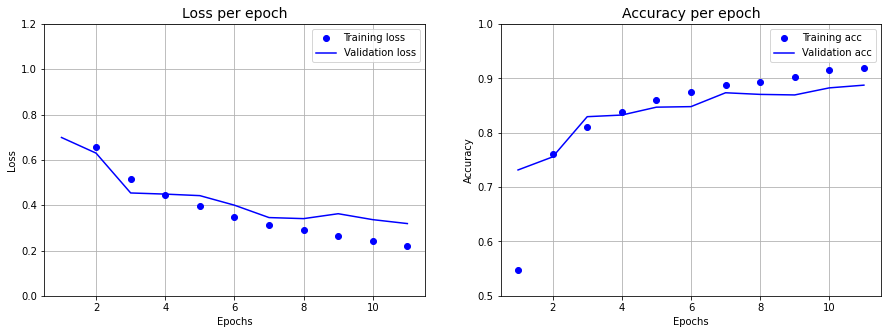

63/63 [==============================] - 3s 44ms/step - loss: 0.3322 - accuracy: 0.8890
Test loss: 0.3321758210659027
Test accuracy: 0.8889999985694885


In [ ]:
# Convolutional layers
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(28, 28, 1),padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model_run_eval(model)

##### __Iteration 9 - applying data augmentation to synthetically increase the volume of images for training__

Results show no improvement so roll back to iteration 8 architecture\
Test loss: 0.5662176609039307\
Test accuracy: 0.7825000286102295\
Significant underfitting

Epoch 1/11
250/250 - 42s - loss: 1.6859 - accuracy: 0.3646 - val_loss: 0.8882 - val_accuracy: 0.6895 - 42s/epoch - 169ms/step
Epoch 2/11
250/250 - 41s - loss: 1.1742 - accuracy: 0.5717 - val_loss: 0.8205 - val_accuracy: 0.6835 - 41s/epoch - 166ms/step
Epoch 3/11
250/250 - 41s - loss: 1.0110 - accuracy: 0.6263 - val_loss: 0.7540 - val_accuracy: 0.7150 - 41s/epoch - 163ms/step
Epoch 4/11
250/250 - 39s - loss: 0.9133 - accuracy: 0.6659 - val_loss: 0.6584 - val_accuracy: 0.7335 - 39s/epoch - 158ms/step
Epoch 5/11
250/250 - 41s - loss: 0.8513 - accuracy: 0.6823 - val_loss: 0.6903 - val_accuracy: 0.7345 - 41s/epoch - 165ms/step
Epoch 6/11
250/250 - 40s - loss: 0.8258 - accuracy: 0.6871 - val_loss: 0.6480 - val_accuracy: 0.7510 - 40s/epoch - 160ms/step
Epoch 7/11
250/250 - 40s - loss: 0.7786 - accuracy: 0.7086 - val_loss: 0.6818 - val_accuracy: 0.7265 - 40s/epoch - 160ms/step
Epoch 8/11
250/250 - 41s - loss: 0.7566 - accuracy: 0.7169 - val_loss: 0.5727 - val_accuracy: 0.7715 - 41s/epoch - 166

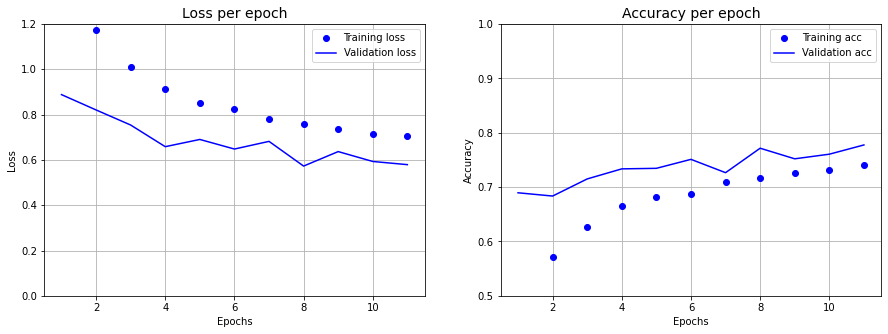

63/63 [==============================] - 3s 49ms/step - loss: 0.5662 - accuracy: 0.7825
Test loss: 0.5662176609039307
Test accuracy: 0.7825000286102295


In [ ]:
# Convolutional layers
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(28, 28, 1),padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

# Compile the convnet
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Create generator with transformation steps
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)

# Fit transformer to the training data
datagen.fit(train_images2)

# Fit the model to the augmented data
# In each epoch all of the original images in training are transformed as per the ImageDataGenerator and used for training
# The number of images in each epoch is equal to the number of original images
# As training has 8,000 samples and batch size is set to 32 then steps per epoch will to be set to 250
# As validation has 2,000 samples and batch size is set to 32 then validation_steps will be set to 63
history = model.fit(datagen.flow(train_images2, train_labels2, batch_size=32),
                    steps_per_epoch=250,
                    epochs=11,
                    validation_data=(valid_images2, valid_labels2),
                    validation_steps=63,
                    verbose=2)

# Plot the training and validation scores by epoch
plot_results(history,0.0,1.2,0.5,1.0)

# Evaluate the model on test dataset
test_loss, test_acc = model.evaluate(test_images2, test_labels2)
print('Test loss:',test_loss)
print('Test accuracy:',test_acc)

#### __b. Evaluate final architecture on full training data__

##### __Get full training data and preprocess__

In [ ]:
# Get full training data
train_images_all = np.concatenate((train_images1, valid_images1))
train_labels_all = np.concatenate((train_labels1, valid_labels1))

# Reshape and standardize the training inputs
train_images_all1=train_images_all.reshape((10000, 28, 28, 1))
train_images_all2=train_images1.astype('float32') / 255

# Reformat training class labels to 0,1 with one hot-encoding
train_labels_all=to_categorical(train_labels_all)

print(train_images_all.shape)
print(train_labels_all.shape)

(10000, 28, 28)
(10000, 10)


##### __Train using finalised architecture and evaluate__

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_149 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 14, 14, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_150 (Conv2D)         (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_104 (MaxPooli  (None, 7, 7, 128)        0         
 ng2D)                                                           
                                                                 
 conv2d_151 (Conv2D)         (None, 7, 7, 128)         147584    
                                                                 
 flatten_59 (Flatten)        (None, 6272)            

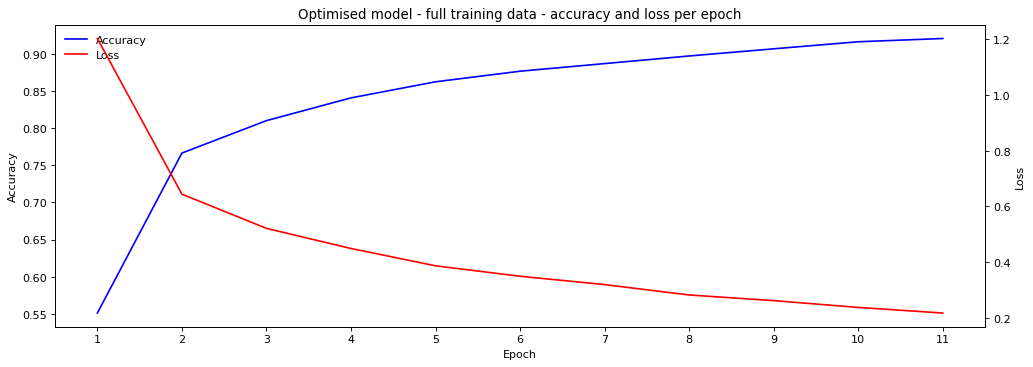

63/63 [==============================] - 3s 42ms/step - loss: 0.3944 - accuracy: 0.8750
Test loss: 0.3943633735179901
Test accuracy: 0.875


In [ ]:
# Convolutional layers
model_final = models.Sequential()
model_final.add(layers.Conv2D(64, (3, 3), activation='relu',input_shape=(28, 28, 1),padding='same'))
model_final.add(layers.MaxPooling2D((2, 2)))
model_final.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model_final.add(layers.MaxPooling2D((2, 2)))
model_final.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))

# Dense layers
model_final.add(layers.Flatten())
model_final.add(layers.Dense(256, activation='relu'))
model_final.add(layers.Dropout(0.25))
model_final.add(layers.Dense(64, activation='relu'))
model_final.add(layers.Dropout(0.25))
model_final.add(layers.Dense(10, activation='softmax'))

# Get model summary
print(model_final.summary())

# Compile
model_final.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# fit
history_final=model_final.fit(train_images2,
                              train_labels2,
                              epochs=11,
                              batch_size=128,
                              verbose=1)

# Plot the loss and accuracy scores by epoch

# Get scores and epochs
acc=history_final.history['accuracy']
loss=history_final.history['loss']
epochs = range(1, len(acc) + 1)

# Create plot
fig, ax1 = plt.subplots(figsize=(15, 5), dpi=80)
ax2 = ax1.twinx()
plot1=ax1.plot(epochs, acc, 'b-', label='Accuracy')
plot2=ax2.plot(epochs, loss, 'r-', label='Loss')
plt.title('Optimised model - full training data - accuracy and loss per epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')
ax1.set_xticks(np.arange(1, len(acc)+1, step=1))
# Create legend
plots=plot1+plot2
labels= [l.get_label() for l in plots]
ax1.legend(plots, labels, loc='best', frameon=False)
plt.show()

# Evaluate the model on test dataset
test_loss, test_acc = model_final.evaluate(test_images2, test_labels2)
print('Test loss:',test_loss)
print('Test accuracy:',test_acc)

##### __Save final model__

In [ ]:
model_final.save('fashion_mnist_final.h5')

## __3. Use a pre-trained convnet to produce a model__

Instead of creating a convnet from scratch on a small dataset of images transfer learning can be undertaken by using a convnet already trained on an extraordinarily large image dataset. Unfortunately there are no pre-trained convnets available for small grayscale images so adjustments had to be made to the Fashion MNIST images before applying them to the Keras pre-trained VGG16 convnet. VGG16 is trained on the ImageNet dataset which contains 1.4 million images associated with 1,000 different classes of everday objects (animate and inanimate).

Using the pre-trained VGG16 convnet we can reuse its convolutional layers (including its weights and biases) and add a new and relevant densely-connected classifier on top of it. The pre-trained classifier of VGG16 was trained on ImageNet classes (1,000 labels) and so needs to be trained on the Fashion MNIST classes. To illustrate the differences in the classes, 'T-shirt' apears in the Fashion MNIST class of 'T-shirt/top' while in ImageNet it is classified as 'jersey, T-shirt, tee shirt' (WekaDeeplearning4j, 2023).

The Fashion MNIST data will be run through the convolutional base and the resulting features will train the new classifier from scratch using the classes of Fashion MNIST. The fully connected dense layers will simply comprise one input layer and one softmax output layer.

To account for the problem of the Fashion MNIST images being being incompatible with VGG16, the shape of the input tensors needed to be transformed from 28 x 28 x 1 to 32 x 32 x 3. Guidance on how to convert of a one grayscale channel to three (fake) RGB channels was taken from an example on stackoverflow (stackoverflow, 2023). Unfortunately, while edges are retained a lot of details within the images are removed so expectations of this achieving good results were low.

As suspected, due to the image transformation, the use of a pretrained convnet achieved only __83.6%__ accuracy for test accuary with the loss and accuracy scores remaining fairly constant across the epochs - this maybe a result of the poor image quality. Applying fine tuning on the the top layers of the convolutional base and the dense layers - to make the higher level abstract representations more relevant for the problem at hand (Chollet, 2018) - resulted in a slightly higher test accuracy score of: __84.5%__ which is noticeably lower than the test accuracy for the optimal model (__87.5__).

#### __a. Data preparation__

##### Create RGB channels for each image

In [ ]:
# Original data
print(train_images1.shape)
print(valid_images2.shape)
print(test_images2.shape)

(8000, 28, 28)
(2000, 28, 28, 1)
(2000, 28, 28, 1)


In [ ]:
# Expand channels
train_images_rgb = np.repeat(train_images1[..., np.newaxis], 3, -1)
valid_images_rgb = np.repeat(valid_images1[..., np.newaxis], 3, -1)
test_images_rgb = np.repeat(test_images1[..., np.newaxis], 3, -1)

In [ ]:
print(train_images_rgb.shape)
print(valid_images_rgb.shape)
print(test_images_rgb.shape)

(8000, 28, 28, 3)
(2000, 28, 28, 3)
(2000, 28, 28, 3)


##### Increase the size of the images

In [ ]:
train_images_rgb1 = tf.image.resize(train_images_rgb, [32,32])
valid_images_rgb1 = tf.image.resize(valid_images_rgb, [32,32])
test_images_rgb1 = tf.image.resize(test_images_rgb, [32,32])

In [ ]:
print(train_images_rgb1.shape)
print(valid_images_rgb1.shape)
print(test_images_rgb1.shape)

(8000, 32, 32, 3)
(2000, 32, 32, 3)
(2000, 32, 32, 3)


##### Check a sample image before vs after transformation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


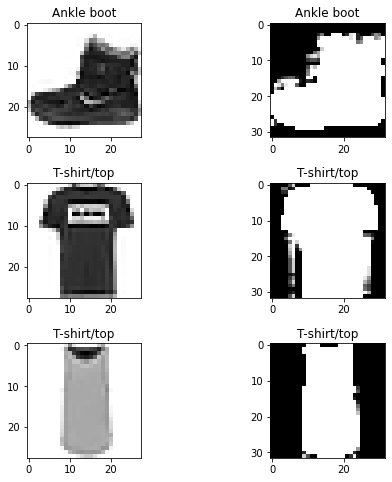

In [ ]:
plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=0.40)

plt.subplot(3,2,1)
plt.imshow(train_images1[0], cmap=plt.cm.binary)
plt.title(class_names[train_labels1[0]])

plt.subplot(3,2,2)
plt.imshow(train_images_rgb1[0], cmap=plt.cm.binary)
plt.title(class_names[train_labels1[0]])

plt.subplot(3,2,3)
plt.imshow(train_images1[1], cmap=plt.cm.binary)
plt.title(class_names[train_labels1[1]])

plt.subplot(3,2,4)
plt.imshow(train_images_rgb1[1], cmap=plt.cm.binary)
plt.title(class_names[train_labels1[1]])

plt.subplot(3,2,5)
plt.imshow(train_images1[2], cmap=plt.cm.binary)
plt.title(class_names[train_labels1[2]])

plt.subplot(3,2,6)
plt.imshow(train_images_rgb1[2], cmap=plt.cm.binary)
plt.title(class_names[train_labels1[2]])

plt.show();

#### __b. Import pretrained VGG16 convnet__

In [ ]:
# Extract the weights of VGG16 but exclude the densely-connected classifer

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32,32,3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

#### __c. Create network__

In [ ]:
model = models.Sequential()

# Convolutional layers
model.add(conv_base)

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

# Get model summary
model.summary()

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_61 (Flatten)        (None, 512)               0         
                                                                 
 dense_157 (Dense)           (None, 256)               131328    
                                                                 
 dropout_58 (Dropout)        (None, 256)               0         
                                                                 
 dense_158 (Dense)           (None, 10)                2570      
                                                                 
Total params: 14,848,586
Trainable params: 14,848,586
Non-trainable params: 0
_________________________________________________________________


#### __d. Train model and evaluate__

Epoch 1/11
63/63 [==============================] - 133s 2s/step - loss: 0.0336 - accuracy: 0.9464 - val_loss: 0.1086 - val_accuracy: 0.8250
Epoch 2/11
63/63 [==============================] - 133s 2s/step - loss: 0.0333 - accuracy: 0.9479 - val_loss: 0.1085 - val_accuracy: 0.8260
Epoch 3/11
63/63 [==============================] - 133s 2s/step - loss: 0.0332 - accuracy: 0.9463 - val_loss: 0.1085 - val_accuracy: 0.8265
Epoch 4/11
63/63 [==============================] - 136s 2s/step - loss: 0.0325 - accuracy: 0.9473 - val_loss: 0.1085 - val_accuracy: 0.8280
Epoch 5/11
63/63 [==============================] - 134s 2s/step - loss: 0.0319 - accuracy: 0.9498 - val_loss: 0.1085 - val_accuracy: 0.8265
Epoch 6/11
63/63 [==============================] - 133s 2s/step - loss: 0.0308 - accuracy: 0.9517 - val_loss: 0.1086 - val_accuracy: 0.8275
Epoch 7/11
63/63 [==============================] - 132s 2s/step - loss: 0.0319 - accuracy: 0.9498 - val_loss: 0.1086 - val_accuracy: 0.8270
Epoch 8/11
63

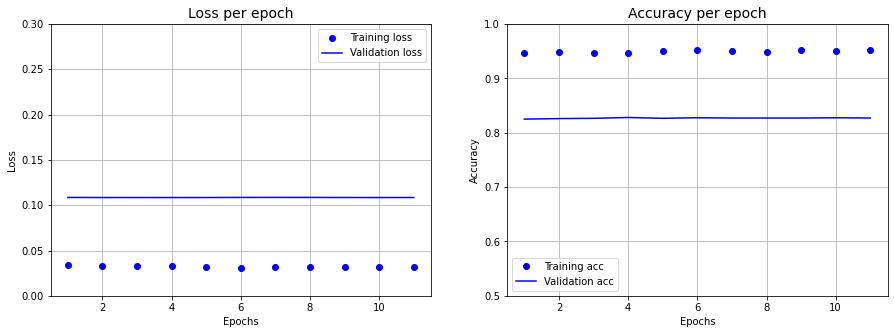

63/63 [==============================] - 27s 426ms/step - loss: 0.1034 - accuracy: 0.8360
Test loss: 0.10338427871465683
Test accuracy: 0.8360000252723694


In [ ]:
# Freeze the convolutional layers so as not to be retrained
conv_base.trainable=False

# Compile
# Here Chollet advises 'using a very small learning rate to limit the magnitude of the modifications being made to the layers being tuned. Updates that are too
# large may harm their representations.'
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

# Fit using same number of epochs as per optimal model created above
history=model.fit(train_images_rgb1,
                  train_labels2,
                  epochs=11,
                  batch_size=128,
                  validation_data=(valid_images_rgb1, valid_labels2),
                  verbose=1)

# Plot the training and validation scores by epoch
plot_results(history,0.0,0.3,0.5,1.0)

# Evaluate the model on test dataset
test_loss, test_acc = model.evaluate(test_images_rgb1, test_labels2)
print('Test loss:',test_loss)
print('Test accuracy:',test_acc)

#### __e. Fine tune the block 5 convolutional and dense layers and evaluate__

Epoch 1/11
63/63 [==============================] - 366s 6s/step - loss: 0.0340 - accuracy: 0.9439 - val_loss: 0.1061 - val_accuracy: 0.8315
Epoch 2/11
63/63 [==============================] - 365s 6s/step - loss: 0.0294 - accuracy: 0.9570 - val_loss: 0.1088 - val_accuracy: 0.8380
Epoch 3/11
63/63 [==============================] - 343s 5s/step - loss: 0.0263 - accuracy: 0.9591 - val_loss: 0.1084 - val_accuracy: 0.8370
Epoch 4/11
63/63 [==============================] - 343s 5s/step - loss: 0.0253 - accuracy: 0.9616 - val_loss: 0.1091 - val_accuracy: 0.8340
Epoch 5/11
63/63 [==============================] - 366s 6s/step - loss: 0.0221 - accuracy: 0.9695 - val_loss: 0.1071 - val_accuracy: 0.8395
Epoch 6/11
63/63 [==============================] - 355s 6s/step - loss: 0.0200 - accuracy: 0.9726 - val_loss: 0.1103 - val_accuracy: 0.8425
Epoch 7/11
63/63 [==============================] - 340s 5s/step - loss: 0.0194 - accuracy: 0.9721 - val_loss: 0.1086 - val_accuracy: 0.8475
Epoch 8/11
63

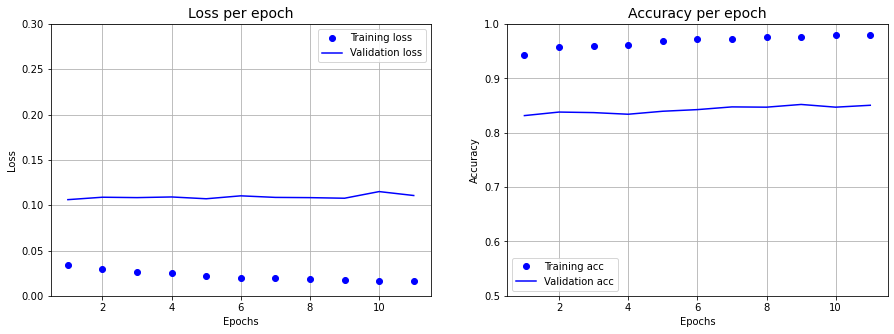

63/63 [==============================] - 27s 433ms/step - loss: 0.1078 - accuracy: 0.8450
Test loss: 0.10779331624507904
Test accuracy: 0.8450000286102295


In [ ]:
# This code is taken from Deep Learning with Python (Chollett, 2018)

# Freeze all the layers up to block 5 in the convolutional layers

# Firstly, unfreeze the convolutional layers (previously frozen above)
conv_base.trainable = True

# Freeze the required layers
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Compile the model

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

# Fit using same number of epochs as per optimal model created above
history=model.fit(train_images_rgb1,
                  train_labels2,
                  epochs=11,
                  batch_size=128,
                  validation_data=(valid_images_rgb1, valid_labels2),
                  verbose=1)

# Plot the training and validation scores by epoch
plot_results(history,0.0,0.3,0.5,1.0)

# Evaluate the model on test dataset
test_loss, test_acc = model.evaluate(test_images_rgb1, test_labels2)
print('Test loss:',test_loss)
print('Test accuracy:',test_acc)

## __4. Summary and conclusions__

This project set out to build a multiclass classification model for image data using neural networks design for image processing - convolutional networks. Using a subset of the full dataset an optimal model was created which did not underfit or overfit the data. Cherry picking key hyperparameters was valuable in optimising during the model build, namely:

- reducing the number of epochs
- adding drop regularisation
- increasing the filter patch size slightly
- incorporating padding to get the most information for output feature maps

Reducing the number of layers and units, utilising synthetic images via data augmentation, and applying other regularization techniques such as L1, batch normalisation did not help with reducing overfitting.

The final model achieved an accuracy score of __87.5%__ which easily passed the evaluation criterion of beating the baseline model - by __12.5__ percentage points.  While I'm please with how the workflow process was used to obtain a final model with significant statistical power based on a small dataset, the accuracy score is considerably less than other benchmarks available online where scores of mid to high 90s are being achieved for the Fashion MNIST dataset. It remains to be seen what benchmarks are available for builds involving small subsets of the Fashion MNIST data. It's key advantage is processing speed in the absence of GPU availability. But also I wanted to see how effective data augmentation could be.

The use of a pre-trained convnet (VGG16) did not perform well which may be due to the hack applied to the input data images. The fine tuning of the model achieved from using the pretrained convnet did however improve the untuned model, but not enough to beat the optimal model.



Given hindsight, If this project was to be repeated I would consider these aspects:
- gain access to a GPU so can process full datasets and still undertake data augmentations. I am sure better results would be achieved with more data
- use a different dataset so that a pre-trained convnet could be used more successfully
- use k-fold validation for evaluating model performance
- include more visual evaluation figures like confusion matrices

## __5. References__

1. Chollet, F. _Deep learning with Python_, first edition 2018
2. TensorFlow, _Basic classification: Classify images of clothing_, found at https://www.tensorflow.org/tutorials/keras/classification (2023)
2. Keras, _Fashion MNIST dataset, an alternative to MNIST_, found at https://keras.io/api/datasets/fashion_mnist/, 2023
3. WekaDeeplearning4j, _IMAGENET 1000 Class List_, found at https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/, 2023
4. stackoverflow, _How can I use a pre-trained neural network with grayscale images?_, found at https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images, 2023